In [1]:
!nvidia-smi

Mon Sep  9 11:59:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   29C    P8             24W /  170W |    1021MiB /  12288MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
import torch
import torchvision
import  torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image

In [22]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),                # Resize the image to 28x28 pixels  
    transforms.ToTensor(),                      # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize R, G, B channels
])

In [23]:
training_set = torchvision.datasets.CIFAR100(
    './data',
    train=True,
    transform=transform,
    download=True
)
validation_set = torchvision.datasets.CIFAR100(

    './data',
    train=False,
    transform=transform,
    download=True
)


Files already downloaded and verified
Files already downloaded and verified


In [24]:
image, label =  training_set[4]
print(image.shape)
print(label)
print(len(training_set.classes))

torch.Size([3, 28, 28])
1
100


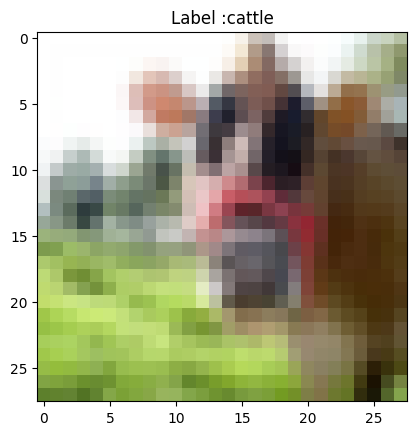

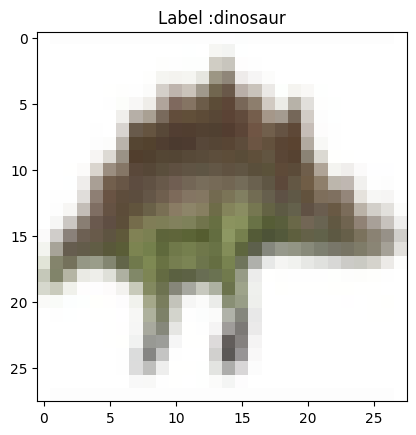

In [25]:
import matplotlib.pyplot as plt
import numpy as np
for i in range(2):
    image , label = training_set[i]
    image = image / 2 + 0.5
    plt.imshow(image.permute(1,2,0)) # 0th dimension should come last and 1st and 2nd dimension should come first
    plt.title("Label :{}".format(training_set.classes[label]))
    plt.show()

In [26]:
def compute_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [27]:
device = compute_device()
device

device(type='cuda')

In [28]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [29]:
class DeviceDataLoader():
    def __init__(self,data_loader,device) -> None:
        self.data_loader = data_loader
        self.device = device
    
    def __iter__(self):
        for batch in self.data_loader:
            yield to_device(batch,self.device)

    def __len__(self):
        return len(self.data_loader)

In [30]:
import torch.utils


training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=4096,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=4096,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
train_loader = DeviceDataLoader(training_loader,device)
val_loader = DeviceDataLoader(validation_loader,device)

Target:  tensor([44, 54, 67, 34, 10, 58, 38, 37, 76,  1, 95, 35, 51, 72, 45, 98, 47,  5,
        71, 94,  3, 29, 33, 16,  2, 75, 69, 27, 15, 19, 19, 46,  3, 50, 18, 97,
        70, 65, 84, 87, 45, 78, 17, 93, 17, 83, 88, 77, 46, 17,  1, 60, 46, 84,
        71, 21, 77, 45, 96, 33, 80, 87, 40,  0, 81, 59, 55, 30, 12, 66, 69, 48,
        41, 52, 54, 82, 18, 96, 59,  9,  0, 70, 15, 68, 26,  2,  9, 35, 25, 59,
        43, 56, 30, 53,  9, 27, 61, 89, 57, 99])


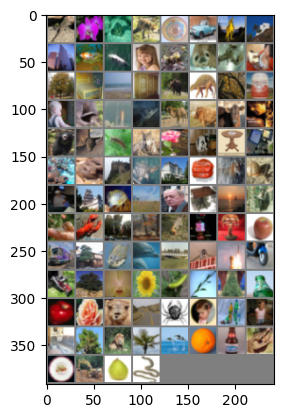

In [31]:

def show_image(img: torch.Tensor):
  img = img / 2 + 0.5
  plt.imshow(img.permute(1,2,0))

dataiter = iter(training_loader)
num_images_to_display = 100
images, labels = next(dataiter)
if images.size(0) > num_images_to_display:
    images = images[:num_images_to_display]
    labels = labels[:num_images_to_display]
img_grid = torchvision.utils.make_grid(images)


show_image(img_grid)
print("Target: ", labels)

In [33]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.first_layer = nn.Linear(
        2352, 
        1024 
    )
    self.first_activation = nn.ReLU() # activation relu

   
    self.second_layer = nn.Sequential(
        nn.Linear(1024, 512),
        nn.ReLU()
    )

    self.output = nn.Sequential(
        nn.Linear(512, 100),
        nn.Softmax(dim=-1)
    )

  def forward(self, x):
    x = self.flatten(x)
    x = self.first_layer(x)
    x = self.first_activation(x)
    x = self.second_layer(x)
    x = self.output(x)
    return x

In [34]:
x = torch.randn(1, 3, 64, 64)
net = Net()
net.eval()
with torch.no_grad():
    probs = net(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x12288 and 2352x1024)

In [35]:
print(probs)
print(probs.sum())

tensor([[0.0080, 0.0086, 0.0088, 0.0103, 0.0102, 0.0101, 0.0096, 0.0119, 0.0111,
         0.0104, 0.0103, 0.0092, 0.0076, 0.0087, 0.0102, 0.0096, 0.0101, 0.0102,
         0.0082, 0.0113, 0.0104, 0.0098, 0.0086, 0.0101, 0.0109, 0.0109, 0.0107,
         0.0102, 0.0091, 0.0103, 0.0093, 0.0099, 0.0117, 0.0083, 0.0098, 0.0086,
         0.0083, 0.0085, 0.0099, 0.0087, 0.0088, 0.0108, 0.0096, 0.0110, 0.0130,
         0.0107, 0.0123, 0.0098, 0.0096, 0.0101, 0.0104, 0.0092, 0.0094, 0.0119,
         0.0100, 0.0100, 0.0093, 0.0099, 0.0110, 0.0113, 0.0118, 0.0106, 0.0100,
         0.0099, 0.0091, 0.0109, 0.0119, 0.0117, 0.0090, 0.0091, 0.0126, 0.0081,
         0.0135, 0.0095, 0.0112, 0.0092, 0.0087, 0.0090, 0.0094, 0.0115, 0.0105,
         0.0084, 0.0105, 0.0103, 0.0096, 0.0098, 0.0083, 0.0111, 0.0125, 0.0105,
         0.0108, 0.0084, 0.0108, 0.0086, 0.0099, 0.0099, 0.0104, 0.0086, 0.0082,
         0.0096]])
tensor(1.)


In [36]:
net = Net()
net = to_device(Net(), device)

In [37]:

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [38]:
from tqdm import tqdm
def train_one_epoch(epoch):
    total_loss = 0
    train_tqdm = tqdm(enumerate(train_loader), total=len(train_loader))

    for i, data in train_tqdm:
        inputs, labels = data

        outputs = net(inputs)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        train_tqdm.set_description(f"Epoch {epoch}: Total loss: {total_loss/(i + 1)}")

    return total_loss / len(training_loader)

In [39]:
num_epochs = 1000
best_acc = 0

for epoch in range(1, num_epochs + 1, 1):

    net.train(True)
    train_loss = train_one_epoch(epoch)

    preds = []
    gts = []

    net.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            outputs = torch.argmax(outputs, dim=-1)
            gts += labels.tolist()
            preds += outputs.tolist()

    # tính acc
    acc = torch.sum(
        torch.tensor(gts) == torch.tensor(preds)
    )/len(gts)

    print(f"Epoch {epoch}: Val acc = {acc}")

    if acc >= best_acc:
        best_acc = acc
        model_path = 'model_{}_{}'.format(epoch, acc)
        torch.save(net.state_dict(), model_path) # lưu mô hình

Epoch 1: Total loss: 4.603879268352802: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s]


Epoch 1: Val acc = 0.0430000014603138


Epoch 2: Total loss: 4.5958787477933445: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Epoch 2: Val acc = 0.040699999779462814


Epoch 3: Total loss: 4.577211746802697: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Epoch 3: Val acc = 0.053700000047683716


Epoch 4: Total loss: 4.562360836909368: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Epoch 4: Val acc = 0.06369999796152115


Epoch 5: Total loss: 4.553563081301176: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s] 


Epoch 5: Val acc = 0.0689999982714653


Epoch 6: Total loss: 4.546447863945594: 100%|██████████| 13/13 [00:11<00:00,  1.18it/s]


Epoch 6: Val acc = 0.08160000294446945


Epoch 7: Total loss: 4.539377616002009: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Epoch 7: Val acc = 0.08839999884366989


Epoch 8: Total loss: 4.5324614231403055: 100%|██████████| 13/13 [00:11<00:00,  1.18it/s]


Epoch 8: Val acc = 0.09700000286102295


Epoch 9: Total loss: 4.525397043961745: 100%|██████████| 13/13 [00:11<00:00,  1.18it/s]


Epoch 9: Val acc = 0.10209999978542328


Epoch 10: Total loss: 4.519830263577974: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Epoch 10: Val acc = 0.11050000041723251


Epoch 11: Total loss: 4.512324626629169: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Epoch 11: Val acc = 0.11429999768733978


Epoch 12: Total loss: 4.507089871626634: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Epoch 12: Val acc = 0.11890000104904175


Epoch 13: Total loss: 4.502601623535156: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Epoch 13: Val acc = 0.12409999966621399


Epoch 14: Total loss: 4.496988920065073: 100%|██████████| 13/13 [00:11<00:00,  1.18it/s]


Epoch 14: Val acc = 0.12860000133514404


Epoch 15: Total loss: 4.492690416482779: 100%|██████████| 13/13 [00:10<00:00,  1.18it/s]


Epoch 15: Val acc = 0.13109999895095825


Epoch 16: Total loss: 4.488410949707031: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Epoch 16: Val acc = 0.13500000536441803


Epoch 17: Total loss: 4.484690556159387: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s] 


Epoch 17: Val acc = 0.13770000636577606


Epoch 18: Total loss: 4.482089922978328: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


Epoch 18: Val acc = 0.13779999315738678


Epoch 19: Total loss: 4.479483200953557: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 19: Val acc = 0.13860000669956207


Epoch 20: Total loss: 4.476600830371563: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 20: Val acc = 0.14069999754428864


Epoch 21: Total loss: 4.473852671109713: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 21: Val acc = 0.1420000046491623


Epoch 22: Total loss: 4.472287618196928: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 22: Val acc = 0.1429000049829483


Epoch 23: Total loss: 4.470061632303091: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 23: Val acc = 0.14470000565052032


Epoch 24: Total loss: 4.466600528130164: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 24: Val acc = 0.1459999978542328


Epoch 25: Total loss: 4.464354331676777: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 25: Val acc = 0.14659999310970306


Epoch 26: Total loss: 4.462798888866718: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 26: Val acc = 0.14990000426769257


Epoch 27: Total loss: 4.460823866037222: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 27: Val acc = 0.149399995803833


Epoch 28: Total loss: 4.460022009336031: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 28: Val acc = 0.15219999849796295


Epoch 29: Total loss: 4.456546673407922: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 29: Val acc = 0.1526000052690506


Epoch 30: Total loss: 4.455683671511137: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 30: Val acc = 0.15160000324249268


Epoch 31: Total loss: 4.454542746910682: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 31: Val acc = 0.1543000042438507


Epoch 32: Total loss: 4.453732857337365: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 32: Val acc = 0.15360000729560852


Epoch 33: Total loss: 4.449099430671105: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 33: Val acc = 0.15539999306201935


Epoch 34: Total loss: 4.450538231776311: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 34: Val acc = 0.15700000524520874


Epoch 35: Total loss: 4.4473388745234566: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 35: Val acc = 0.15680000185966492


Epoch 36: Total loss: 4.4469170937171345: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 36: Val acc = 0.1565999984741211


Epoch 37: Total loss: 4.444752069619986: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 37: Val acc = 0.15860000252723694


Epoch 38: Total loss: 4.443955788245568: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 38: Val acc = 0.1599999964237213


Epoch 39: Total loss: 4.4431047072777385: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 39: Val acc = 0.1597999930381775


Epoch 40: Total loss: 4.441676910106953: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 40: Val acc = 0.16060000658035278


Epoch 41: Total loss: 4.439224426562969: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 41: Val acc = 0.1606999933719635


Epoch 42: Total loss: 4.439429980057937: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 42: Val acc = 0.16169999539852142


Epoch 43: Total loss: 4.439062778766338: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 43: Val acc = 0.16339999437332153


Epoch 44: Total loss: 4.43644013771644: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 44: Val acc = 0.16419999301433563


Epoch 45: Total loss: 4.434978998624361: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 45: Val acc = 0.1623000055551529


Epoch 46: Total loss: 4.434649357428918: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s] 


Epoch 46: Val acc = 0.16500000655651093


Epoch 47: Total loss: 4.434076052445632: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 47: Val acc = 0.16349999606609344


Epoch 48: Total loss: 4.430704703697791: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 48: Val acc = 0.16539999842643738


Epoch 49: Total loss: 4.43135246863732: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s] 


Epoch 49: Val acc = 0.16459999978542328


Epoch 50: Total loss: 4.430113792419434: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 50: Val acc = 0.16580000519752502


Epoch 51: Total loss: 4.428366477672871: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 51: Val acc = 0.16680000722408295


Epoch 52: Total loss: 4.427339553833008: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 52: Val acc = 0.16680000722408295


Epoch 53: Total loss: 4.427472004523644: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 53: Val acc = 0.16760000586509705


Epoch 54: Total loss: 4.425460301912748: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 54: Val acc = 0.16689999401569366


Epoch 55: Total loss: 4.424370142129751: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 55: Val acc = 0.16830000281333923


Epoch 56: Total loss: 4.423323447887714: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 56: Val acc = 0.16840000450611115


Epoch 57: Total loss: 4.42127066392165: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 57: Val acc = 0.16979999840259552


Epoch 58: Total loss: 4.42115725003756: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 58: Val acc = 0.16899999976158142


Epoch 59: Total loss: 4.4204595272357645: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 59: Val acc = 0.1703999936580658


Epoch 60: Total loss: 4.418725123772254: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 60: Val acc = 0.1704999953508377


Epoch 61: Total loss: 4.420225730309119: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 61: Val acc = 0.1712000072002411


Epoch 62: Total loss: 4.416165938744178: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 62: Val acc = 0.1703999936580658


Epoch 63: Total loss: 4.4160967239966755: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 63: Val acc = 0.17319999635219574


Epoch 64: Total loss: 4.416482742016132: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 64: Val acc = 0.17180000245571136


Epoch 65: Total loss: 4.414478632119986: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 65: Val acc = 0.17260000109672546


Epoch 66: Total loss: 4.41427494929387: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]  


Epoch 66: Val acc = 0.1738000065088272


Epoch 67: Total loss: 4.4125668452336235: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 67: Val acc = 0.17430000007152557


Epoch 68: Total loss: 4.41235641332773: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 68: Val acc = 0.17319999635219574


Epoch 69: Total loss: 4.40995979309082: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s] 


Epoch 69: Val acc = 0.17180000245571136


Epoch 70: Total loss: 4.411856614626371: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 70: Val acc = 0.17329999804496765


Epoch 71: Total loss: 4.409205730144794: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 71: Val acc = 0.17489999532699585


Epoch 72: Total loss: 4.408918564136211: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 72: Val acc = 0.1753000020980835


Epoch 73: Total loss: 4.406062346238357: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 73: Val acc = 0.17589999735355377


Epoch 74: Total loss: 4.406227515294002: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 74: Val acc = 0.17569999396800995


Epoch 75: Total loss: 4.406324313237117: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 75: Val acc = 0.17630000412464142


Epoch 76: Total loss: 4.405619547917293: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 76: Val acc = 0.1761000007390976


Epoch 77: Total loss: 4.402842228229229: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 77: Val acc = 0.17649999260902405


Epoch 78: Total loss: 4.403621526864859: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 78: Val acc = 0.17649999260902405


Epoch 79: Total loss: 4.403077969184289: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 79: Val acc = 0.17579999566078186


Epoch 80: Total loss: 4.4032716017503: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]  


Epoch 80: Val acc = 0.1768999993801117


Epoch 81: Total loss: 4.400822235987737: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 81: Val acc = 0.1768999993801117


Epoch 82: Total loss: 4.399436290447529: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 82: Val acc = 0.17589999735355377


Epoch 83: Total loss: 4.399952998528113: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 83: Val acc = 0.1770000010728836


Epoch 84: Total loss: 4.397766590118408: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 84: Val acc = 0.17759999632835388


Epoch 85: Total loss: 4.399338172032283: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 85: Val acc = 0.1777999997138977


Epoch 86: Total loss: 4.396658493922307: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 86: Val acc = 0.17800000309944153


Epoch 87: Total loss: 4.396618182842548: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 87: Val acc = 0.17810000479221344


Epoch 88: Total loss: 4.3956427574157715: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 88: Val acc = 0.17659999430179596


Epoch 89: Total loss: 4.395214080810547: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 89: Val acc = 0.17640000581741333


Epoch 90: Total loss: 4.394264111152062: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 90: Val acc = 0.1784999966621399


Epoch 91: Total loss: 4.3950946147625265: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 91: Val acc = 0.17829999327659607


Epoch 92: Total loss: 4.391818413367639: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 92: Val acc = 0.17759999632835388


Epoch 93: Total loss: 4.392781587747427: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 93: Val acc = 0.179299995303154


Epoch 94: Total loss: 4.391130520747258: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 94: Val acc = 0.17960000038146973


Epoch 95: Total loss: 4.390777404491718: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 95: Val acc = 0.17870000004768372


Epoch 96: Total loss: 4.390743549053486: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 96: Val acc = 0.17910000681877136


Epoch 97: Total loss: 4.390441527733436: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 97: Val acc = 0.17870000004768372


Epoch 98: Total loss: 4.390887223757231: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 98: Val acc = 0.1809999942779541


Epoch 99: Total loss: 4.388559158031757: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 99: Val acc = 0.17900000512599945


Epoch 100: Total loss: 4.389178349421575: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 100: Val acc = 0.1793999969959259


Epoch 101: Total loss: 4.387619642110971: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 101: Val acc = 0.17990000545978546


Epoch 102: Total loss: 4.388024036700909: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 102: Val acc = 0.17970000207424164


Epoch 103: Total loss: 4.386335079486553: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 103: Val acc = 0.18070000410079956


Epoch 104: Total loss: 4.386039036970872: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 104: Val acc = 0.18150000274181366


Epoch 105: Total loss: 4.386656357691838: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 105: Val acc = 0.1800999939441681


Epoch 106: Total loss: 4.38472920197707: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 106: Val acc = 0.18029999732971191


Epoch 107: Total loss: 4.382698242480938: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 107: Val acc = 0.17870000004768372


Epoch 108: Total loss: 4.383218875298133: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 108: Val acc = 0.18140000104904175


Epoch 109: Total loss: 4.38252408687885: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]  


Epoch 109: Val acc = 0.1809999942779541


Epoch 110: Total loss: 4.382351581866924: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 110: Val acc = 0.17990000545978546


Epoch 111: Total loss: 4.38033965917734: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 111: Val acc = 0.18170000612735748


Epoch 112: Total loss: 4.379954484792856: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 112: Val acc = 0.18119999766349792


Epoch 113: Total loss: 4.38090471120981: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 113: Val acc = 0.1808999925851822


Epoch 114: Total loss: 4.382357560671293: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 114: Val acc = 0.18070000410079956


Epoch 115: Total loss: 4.379227454845722: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 115: Val acc = 0.18219999969005585


Epoch 116: Total loss: 4.380703926086426: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 116: Val acc = 0.18150000274181366


Epoch 117: Total loss: 4.378535454089825: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 117: Val acc = 0.18250000476837158


Epoch 118: Total loss: 4.37810494349553: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 118: Val acc = 0.18080000579357147


Epoch 119: Total loss: 4.376641860375037: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 119: Val acc = 0.18029999732971191


Epoch 120: Total loss: 4.376562485328088: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 120: Val acc = 0.18160000443458557


Epoch 121: Total loss: 4.37638755945059: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 121: Val acc = 0.1809999942779541


Epoch 122: Total loss: 4.3753725198599005: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 122: Val acc = 0.1817999929189682


Epoch 123: Total loss: 4.373225395496075: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 123: Val acc = 0.18310000002384186


Epoch 124: Total loss: 4.375506180983323: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 124: Val acc = 0.18140000104904175


Epoch 125: Total loss: 4.374594908494216: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 125: Val acc = 0.1826999932527542


Epoch 126: Total loss: 4.374718409318191: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 126: Val acc = 0.18119999766349792


Epoch 127: Total loss: 4.375939882718599: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 127: Val acc = 0.18129999935626984


Epoch 128: Total loss: 4.373723250169021: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 128: Val acc = 0.1817999929189682


Epoch 129: Total loss: 4.37297850388747: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 129: Val acc = 0.1817999929189682


Epoch 130: Total loss: 4.372196857745831: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 130: Val acc = 0.18209999799728394


Epoch 131: Total loss: 4.370477456312913: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 131: Val acc = 0.1826000064611435


Epoch 132: Total loss: 4.371733335348276: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 132: Val acc = 0.1826000064611435


Epoch 133: Total loss: 4.370093308962309: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 133: Val acc = 0.18199999630451202


Epoch 134: Total loss: 4.3682756423950195: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 134: Val acc = 0.1826000064611435


Epoch 135: Total loss: 4.37036657333374: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]  


Epoch 135: Val acc = 0.18310000002384186


Epoch 136: Total loss: 4.369787032787617: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 136: Val acc = 0.1834000051021576


Epoch 137: Total loss: 4.36847107227032: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 137: Val acc = 0.18320000171661377


Epoch 138: Total loss: 4.368851991800161: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 138: Val acc = 0.1826999932527542


Epoch 139: Total loss: 4.367646254025972: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 139: Val acc = 0.18289999663829803


Epoch 140: Total loss: 4.367109592144306: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 140: Val acc = 0.18320000171661377


Epoch 141: Total loss: 4.367330074310303: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 141: Val acc = 0.18219999969005585


Epoch 142: Total loss: 4.366827818063589: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 142: Val acc = 0.1835000067949295


Epoch 143: Total loss: 4.365512994619516: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 143: Val acc = 0.18410000205039978


Epoch 144: Total loss: 4.365894317626953: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 144: Val acc = 0.1835000067949295


Epoch 145: Total loss: 4.366201400756836: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 145: Val acc = 0.1834000051021576


Epoch 146: Total loss: 4.364199161529541: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 146: Val acc = 0.18330000340938568


Epoch 147: Total loss: 4.364302451793964: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 147: Val acc = 0.18320000171661377


Epoch 148: Total loss: 4.36447286605835: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 148: Val acc = 0.18410000205039978


Epoch 149: Total loss: 4.363602748283973: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 149: Val acc = 0.18369999527931213


Epoch 150: Total loss: 4.362255683312049: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 150: Val acc = 0.18240000307559967


Epoch 151: Total loss: 4.361174730154184: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 151: Val acc = 0.1835000067949295


Epoch 152: Total loss: 4.36347851386437: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 152: Val acc = 0.1834000051021576


Epoch 153: Total loss: 4.361344154064472: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 153: Val acc = 0.18369999527931213


Epoch 154: Total loss: 4.363035312065711: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 154: Val acc = 0.18379999697208405


Epoch 155: Total loss: 4.361739562107966: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 155: Val acc = 0.1826000064611435


Epoch 156: Total loss: 4.36209590618427: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 156: Val acc = 0.18490000069141388


Epoch 157: Total loss: 4.360081342550425: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 157: Val acc = 0.18479999899864197


Epoch 158: Total loss: 4.36012392777663: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 158: Val acc = 0.1842000037431717


Epoch 159: Total loss: 4.3605996278616095: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 159: Val acc = 0.1851000040769577


Epoch 160: Total loss: 4.359085486485408: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 160: Val acc = 0.18379999697208405


Epoch 161: Total loss: 4.359483828911414: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 161: Val acc = 0.18559999763965607


Epoch 162: Total loss: 4.357471282665546: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 162: Val acc = 0.18529999256134033


Epoch 163: Total loss: 4.358153636638935: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 163: Val acc = 0.18490000069141388


Epoch 164: Total loss: 4.356424331665039: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 164: Val acc = 0.1858000010251999


Epoch 165: Total loss: 4.3565557186420145: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 165: Val acc = 0.18400000035762787


Epoch 166: Total loss: 4.356498608222375: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 166: Val acc = 0.18619999289512634


Epoch 167: Total loss: 4.357365461496206: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 167: Val acc = 0.18490000069141388


Epoch 168: Total loss: 4.357574242811936: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 168: Val acc = 0.18479999899864197


Epoch 169: Total loss: 4.355999139639048: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 169: Val acc = 0.18569999933242798


Epoch 170: Total loss: 4.355196255903977: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 170: Val acc = 0.1859000027179718


Epoch 171: Total loss: 4.356192625485933: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 171: Val acc = 0.1875


Epoch 172: Total loss: 4.354934032146748: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 172: Val acc = 0.18649999797344208


Epoch 173: Total loss: 4.354704049917368: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 173: Val acc = 0.18610000610351562


Epoch 174: Total loss: 4.3557562461266155: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 174: Val acc = 0.1859000027179718


Epoch 175: Total loss: 4.353266679323637: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 175: Val acc = 0.18549999594688416


Epoch 176: Total loss: 4.353566609896147: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 176: Val acc = 0.18729999661445618


Epoch 177: Total loss: 4.352118748884934: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 177: Val acc = 0.18610000610351562


Epoch 178: Total loss: 4.35254665521475: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s] 


Epoch 178: Val acc = 0.186599999666214


Epoch 179: Total loss: 4.353425796215351: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 179: Val acc = 0.1868000030517578


Epoch 180: Total loss: 4.352078951322115: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 180: Val acc = 0.18569999933242798


Epoch 181: Total loss: 4.352717399597168: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 181: Val acc = 0.18549999594688416


Epoch 182: Total loss: 4.349967369666467: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 182: Val acc = 0.18639999628067017


Epoch 183: Total loss: 4.3501368669363165: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 183: Val acc = 0.18719999492168427


Epoch 184: Total loss: 4.3512522257291355: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 184: Val acc = 0.18610000610351562


Epoch 185: Total loss: 4.34957636319674: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 185: Val acc = 0.1860000044107437


Epoch 186: Total loss: 4.350375358874981: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 186: Val acc = 0.18690000474452972


Epoch 187: Total loss: 4.349556666154128: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 187: Val acc = 0.1850000023841858


Epoch 188: Total loss: 4.350489689753606: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 188: Val acc = 0.18610000610351562


Epoch 189: Total loss: 4.348426415370061: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 189: Val acc = 0.18719999492168427


Epoch 190: Total loss: 4.350027121030367: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 190: Val acc = 0.18690000474452972


Epoch 191: Total loss: 4.3474100553072414: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 191: Val acc = 0.18729999661445618


Epoch 192: Total loss: 4.34939952997061: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 192: Val acc = 0.18719999492168427


Epoch 193: Total loss: 4.348203952495869: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 193: Val acc = 0.18799999356269836


Epoch 194: Total loss: 4.3457273336557245: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 194: Val acc = 0.18790000677108765


Epoch 195: Total loss: 4.348588173206036: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 195: Val acc = 0.18719999492168427


Epoch 196: Total loss: 4.34732880959144: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s] 


Epoch 196: Val acc = 0.1875


Epoch 197: Total loss: 4.346777989314153: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 197: Val acc = 0.18780000507831573


Epoch 198: Total loss: 4.345991097963774: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 198: Val acc = 0.18709999322891235


Epoch 199: Total loss: 4.346427183884841: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 199: Val acc = 0.1868000030517578


Epoch 200: Total loss: 4.345889421609732: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 200: Val acc = 0.18770000338554382


Epoch 201: Total loss: 4.345350742340088: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 201: Val acc = 0.1881999969482422


Epoch 202: Total loss: 4.344785837026743: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 202: Val acc = 0.1876000016927719


Epoch 203: Total loss: 4.3452145136319675: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 203: Val acc = 0.18850000202655792


Epoch 204: Total loss: 4.345265718606802: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 204: Val acc = 0.1876000016927719


Epoch 205: Total loss: 4.345364130460299: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 205: Val acc = 0.18770000338554382


Epoch 206: Total loss: 4.344295244950515: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 206: Val acc = 0.18780000507831573


Epoch 207: Total loss: 4.34346892283513: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 207: Val acc = 0.18809999525547028


Epoch 208: Total loss: 4.344069700974685: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 208: Val acc = 0.18850000202655792


Epoch 209: Total loss: 4.341811987069937: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 209: Val acc = 0.18850000202655792


Epoch 210: Total loss: 4.342623820671668: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 210: Val acc = 0.1881999969482422


Epoch 211: Total loss: 4.340877863077017: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 211: Val acc = 0.18790000677108765


Epoch 212: Total loss: 4.341839423546424: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 212: Val acc = 0.1881999969482422


Epoch 213: Total loss: 4.3429639889643745: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 213: Val acc = 0.188400000333786


Epoch 214: Total loss: 4.340055025540865: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 214: Val acc = 0.1889999955892563


Epoch 215: Total loss: 4.3418893080491285: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 215: Val acc = 0.18889999389648438


Epoch 216: Total loss: 4.341965418595534: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 216: Val acc = 0.19050000607967377


Epoch 217: Total loss: 4.339292416205773: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 217: Val acc = 0.18870000541210175


Epoch 218: Total loss: 4.341294582073505: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 218: Val acc = 0.18860000371932983


Epoch 219: Total loss: 4.3396908686711235: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 219: Val acc = 0.1882999986410141


Epoch 220: Total loss: 4.339479556450477: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 220: Val acc = 0.1882999986410141


Epoch 221: Total loss: 4.339706274179312: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 221: Val acc = 0.1882999986410141


Epoch 222: Total loss: 4.339028101701003: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 222: Val acc = 0.18960000574588776


Epoch 223: Total loss: 4.3395167130690355: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 223: Val acc = 0.18860000371932983


Epoch 224: Total loss: 4.336224225851206: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 224: Val acc = 0.18970000743865967


Epoch 225: Total loss: 4.337071932279146: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 225: Val acc = 0.1890999972820282


Epoch 226: Total loss: 4.337028980255127: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 226: Val acc = 0.18940000236034393


Epoch 227: Total loss: 4.337554968320406: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 227: Val acc = 0.1898999959230423


Epoch 228: Total loss: 4.335595314319317: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 228: Val acc = 0.1898999959230423


Epoch 229: Total loss: 4.337219825157752: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 229: Val acc = 0.1889999955892563


Epoch 230: Total loss: 4.337265968322754: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 230: Val acc = 0.18970000743865967


Epoch 231: Total loss: 4.335167297950158: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 231: Val acc = 0.18880000710487366


Epoch 232: Total loss: 4.335311706249531: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 232: Val acc = 0.1889999955892563


Epoch 233: Total loss: 4.33692532319289: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 233: Val acc = 0.19009999930858612


Epoch 234: Total loss: 4.336380518399752: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 234: Val acc = 0.18960000574588776


Epoch 235: Total loss: 4.33523783316979: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 235: Val acc = 0.1898999959230423


Epoch 236: Total loss: 4.335076405451848: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 236: Val acc = 0.1899999976158142


Epoch 237: Total loss: 4.333202325380766: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 237: Val acc = 0.18940000236034393


Epoch 238: Total loss: 4.333982907808744: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 238: Val acc = 0.18979999423027039


Epoch 239: Total loss: 4.334735173445481: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


Epoch 239: Val acc = 0.1906999945640564


Epoch 240: Total loss: 4.3337914393498345: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Epoch 240: Val acc = 0.1906999945640564


Epoch 241: Total loss: 4.333304038414588: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 241: Val acc = 0.1898999959230423


Epoch 242: Total loss: 4.334764810708853: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 242: Val acc = 0.19009999930858612


Epoch 243: Total loss: 4.332942962646484: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s]


Epoch 243: Val acc = 0.18970000743865967


Epoch 244: Total loss: 4.330892636225774: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 244: Val acc = 0.19020000100135803


Epoch 245: Total loss: 4.331600812765268: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 245: Val acc = 0.19009999930858612


Epoch 246: Total loss: 4.330723469073956: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 246: Val acc = 0.19059999287128448


Epoch 247: Total loss: 4.332027618701641: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 247: Val acc = 0.18979999423027039


Epoch 248: Total loss: 4.330384291135347: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 248: Val acc = 0.1907999962568283


Epoch 249: Total loss: 4.3298977338350735: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 249: Val acc = 0.18960000574588776


Epoch 250: Total loss: 4.329644239865816: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 250: Val acc = 0.19040000438690186


Epoch 251: Total loss: 4.330094740940974: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 251: Val acc = 0.19059999287128448


Epoch 252: Total loss: 4.329849133124719: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 252: Val acc = 0.19040000438690186


Epoch 253: Total loss: 4.330465977008526: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 253: Val acc = 0.18970000743865967


Epoch 254: Total loss: 4.3299826475290155: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 254: Val acc = 0.19009999930858612


Epoch 255: Total loss: 4.32984212728647: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 255: Val acc = 0.19130000472068787


Epoch 256: Total loss: 4.328490990858811: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 256: Val acc = 0.1906999945640564


Epoch 257: Total loss: 4.329278285686787: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 257: Val acc = 0.1907999962568283


Epoch 258: Total loss: 4.3290348419776326: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Epoch 258: Val acc = 0.18960000574588776


Epoch 259: Total loss: 4.328793525695801: 100%|██████████| 13/13 [00:10<00:00,  1.18it/s]


Epoch 259: Val acc = 0.19059999287128448


Epoch 260: Total loss: 4.327995373652532: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 260: Val acc = 0.1914999932050705


Epoch 261: Total loss: 4.327445617088904: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 261: Val acc = 0.19040000438690186


Epoch 262: Total loss: 4.326416235703689: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 262: Val acc = 0.19030000269412994


Epoch 263: Total loss: 4.327753067016602: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 263: Val acc = 0.19169999659061432


Epoch 264: Total loss: 4.327348782466008: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 264: Val acc = 0.19200000166893005


Epoch 265: Total loss: 4.326835705683782: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 265: Val acc = 0.19210000336170197


Epoch 266: Total loss: 4.327451669252836: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 266: Val acc = 0.19189999997615814


Epoch 267: Total loss: 4.328916476323054: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 267: Val acc = 0.19269999861717224


Epoch 268: Total loss: 4.324849568880522: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 268: Val acc = 0.19429999589920044


Epoch 269: Total loss: 4.325780905210054: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 269: Val acc = 0.19249999523162842


Epoch 270: Total loss: 4.324680805206299: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 270: Val acc = 0.19200000166893005


Epoch 271: Total loss: 4.325574581439678: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 271: Val acc = 0.19300000369548798


Epoch 272: Total loss: 4.3267903327941895: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 272: Val acc = 0.19200000166893005


Epoch 273: Total loss: 4.323170735285832: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 273: Val acc = 0.1923000067472458


Epoch 274: Total loss: 4.3239150780897875: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 274: Val acc = 0.1923000067472458


Epoch 275: Total loss: 4.322049361008864: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 275: Val acc = 0.19220000505447388


Epoch 276: Total loss: 4.324230194091797: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Epoch 276: Val acc = 0.19249999523162842


Epoch 277: Total loss: 4.323075477893536: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


Epoch 277: Val acc = 0.19290000200271606


Epoch 278: Total loss: 4.3229510600750265: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 278: Val acc = 0.1931000053882599


Epoch 279: Total loss: 4.325275567861704: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 279: Val acc = 0.19290000200271606


Epoch 280: Total loss: 4.324267093951885: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 280: Val acc = 0.1932000070810318


Epoch 281: Total loss: 4.324084942157452: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 281: Val acc = 0.19300000369548798


Epoch 282: Total loss: 4.323387806232159: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 282: Val acc = 0.1923000067472458


Epoch 283: Total loss: 4.323716713831975: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 283: Val acc = 0.19290000200271606


Epoch 284: Total loss: 4.321760140932524: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 284: Val acc = 0.19300000369548798


Epoch 285: Total loss: 4.3200381352351265: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 285: Val acc = 0.19269999861717224


Epoch 286: Total loss: 4.322736409994272: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 286: Val acc = 0.19200000166893005


Epoch 287: Total loss: 4.321732044219971: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 287: Val acc = 0.19339999556541443


Epoch 288: Total loss: 4.321137538323035: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 288: Val acc = 0.19370000064373016


Epoch 289: Total loss: 4.322626847487229: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 289: Val acc = 0.1932000070810318


Epoch 290: Total loss: 4.322091029240535: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 290: Val acc = 0.19370000064373016


Epoch 291: Total loss: 4.320588515355037: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 291: Val acc = 0.19269999861717224


Epoch 292: Total loss: 4.320654135483962: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 292: Val acc = 0.19370000064373016


Epoch 293: Total loss: 4.319594346559965: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 293: Val acc = 0.1923999935388565


Epoch 294: Total loss: 4.319269143618071: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 294: Val acc = 0.19220000505447388


Epoch 295: Total loss: 4.320700792165903: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 295: Val acc = 0.19210000336170197


Epoch 296: Total loss: 4.3200548978952265: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 296: Val acc = 0.1915999948978424


Epoch 297: Total loss: 4.320329592778132: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 297: Val acc = 0.19359999895095825


Epoch 298: Total loss: 4.319075511052058: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 298: Val acc = 0.19269999861717224


Epoch 299: Total loss: 4.3181329140296345: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 299: Val acc = 0.19290000200271606


Epoch 300: Total loss: 4.318911515749418: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 300: Val acc = 0.19169999659061432


Epoch 301: Total loss: 4.319480382479155: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 301: Val acc = 0.19280000030994415


Epoch 302: Total loss: 4.317685604095459: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 302: Val acc = 0.19280000030994415


Epoch 303: Total loss: 4.318337183732253: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 303: Val acc = 0.1941000074148178


Epoch 304: Total loss: 4.317671922536997: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 304: Val acc = 0.19269999861717224


Epoch 305: Total loss: 4.317226813389705: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 305: Val acc = 0.19290000200271606


Epoch 306: Total loss: 4.317767510047326: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 306: Val acc = 0.1923000067472458


Epoch 307: Total loss: 4.319113364586463: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 307: Val acc = 0.19269999861717224


Epoch 308: Total loss: 4.31574271275447: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 308: Val acc = 0.1941000074148178


Epoch 309: Total loss: 4.316341876983643: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 309: Val acc = 0.19269999861717224


Epoch 310: Total loss: 4.318091906034029: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 310: Val acc = 0.1923999935388565


Epoch 311: Total loss: 4.3148669096139765: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 311: Val acc = 0.1923000067472458


Epoch 312: Total loss: 4.315696056072529: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 312: Val acc = 0.19370000064373016


Epoch 313: Total loss: 4.317260558788593: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 313: Val acc = 0.19249999523162842


Epoch 314: Total loss: 4.315635167635405: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 314: Val acc = 0.19290000200271606


Epoch 315: Total loss: 4.31562797839825: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 315: Val acc = 0.1923000067472458


Epoch 316: Total loss: 4.315382407261775: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 316: Val acc = 0.1932000070810318


Epoch 317: Total loss: 4.31734822346614: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 317: Val acc = 0.1931000053882599


Epoch 318: Total loss: 4.316004863152137: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 318: Val acc = 0.19280000030994415


Epoch 319: Total loss: 4.31367903489333: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 319: Val acc = 0.19329999387264252


Epoch 320: Total loss: 4.313385743361253: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 320: Val acc = 0.19280000030994415


Epoch 321: Total loss: 4.313764388744648: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 321: Val acc = 0.19210000336170197


Epoch 322: Total loss: 4.3145366081824665: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 322: Val acc = 0.1932000070810318


Epoch 323: Total loss: 4.314754926241362: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 323: Val acc = 0.19370000064373016


Epoch 324: Total loss: 4.312952811901386: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 324: Val acc = 0.19349999725818634


Epoch 325: Total loss: 4.314780932206374: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 325: Val acc = 0.19339999556541443


Epoch 326: Total loss: 4.312859791975755: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 326: Val acc = 0.19179999828338623


Epoch 327: Total loss: 4.313760060530442: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 327: Val acc = 0.19269999861717224


Epoch 328: Total loss: 4.312898672544039: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 328: Val acc = 0.19280000030994415


Epoch 329: Total loss: 4.31316980948815: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 329: Val acc = 0.19269999861717224


Epoch 330: Total loss: 4.312696860386775: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 330: Val acc = 0.19259999692440033


Epoch 331: Total loss: 4.313331383925218: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 331: Val acc = 0.19300000369548798


Epoch 332: Total loss: 4.311478504767785: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 332: Val acc = 0.1931000053882599


Epoch 333: Total loss: 4.312242544614351: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 333: Val acc = 0.19249999523162842


Epoch 334: Total loss: 4.311757234426645: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 334: Val acc = 0.19280000030994415


Epoch 335: Total loss: 4.3118863839369554: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 335: Val acc = 0.1923999935388565


Epoch 336: Total loss: 4.312393591954158: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 336: Val acc = 0.1923999935388565


Epoch 337: Total loss: 4.309954423170823: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 337: Val acc = 0.19249999523162842


Epoch 338: Total loss: 4.310014834770789: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 338: Val acc = 0.19280000030994415


Epoch 339: Total loss: 4.310676758105938: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 339: Val acc = 0.1923999935388565


Epoch 340: Total loss: 4.309898083026592: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 340: Val acc = 0.19200000166893005


Epoch 341: Total loss: 4.3105585391704855: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 341: Val acc = 0.193900004029274


Epoch 342: Total loss: 4.3079897073599005: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 342: Val acc = 0.19290000200271606


Epoch 343: Total loss: 4.308333323552058: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 343: Val acc = 0.19349999725818634


Epoch 344: Total loss: 4.308626908522386: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 344: Val acc = 0.1940000057220459


Epoch 345: Total loss: 4.308513201200045: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 345: Val acc = 0.19380000233650208


Epoch 346: Total loss: 4.310081408574031: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 346: Val acc = 0.19290000200271606


Epoch 347: Total loss: 4.308275552896353: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 347: Val acc = 0.1940000057220459


Epoch 348: Total loss: 4.306240411905142: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 348: Val acc = 0.19259999692440033


Epoch 349: Total loss: 4.307260880103478: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 349: Val acc = 0.1923999935388565


Epoch 350: Total loss: 4.308896908393273: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 350: Val acc = 0.19380000233650208


Epoch 351: Total loss: 4.306820759406457: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 351: Val acc = 0.19290000200271606


Epoch 352: Total loss: 4.307991614708533: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 352: Val acc = 0.193900004029274


Epoch 353: Total loss: 4.3063596945542555: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 353: Val acc = 0.1941000074148178


Epoch 354: Total loss: 4.306924159710224: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 354: Val acc = 0.19380000233650208


Epoch 355: Total loss: 4.306042817922739: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 355: Val acc = 0.19349999725818634


Epoch 356: Total loss: 4.306723264547495: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 356: Val acc = 0.1941000074148178


Epoch 357: Total loss: 4.3056865105262165: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 357: Val acc = 0.19439999759197235


Epoch 358: Total loss: 4.306824867541973: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 358: Val acc = 0.19439999759197235


Epoch 359: Total loss: 4.305939674377441: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 359: Val acc = 0.19419999420642853


Epoch 360: Total loss: 4.305364535405086: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 360: Val acc = 0.19370000064373016


Epoch 361: Total loss: 4.307423958411584: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 361: Val acc = 0.1931000053882599


Epoch 362: Total loss: 4.306622065030611: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 362: Val acc = 0.19339999556541443


Epoch 363: Total loss: 4.306182091052715: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 363: Val acc = 0.1940000057220459


Epoch 364: Total loss: 4.307711601257324: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 364: Val acc = 0.1940000057220459


Epoch 365: Total loss: 4.3063980616056: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]  


Epoch 365: Val acc = 0.19339999556541443


Epoch 366: Total loss: 4.306993777935322: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 366: Val acc = 0.1923999935388565


Epoch 367: Total loss: 4.305891403785119: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 367: Val acc = 0.19349999725818634


Epoch 368: Total loss: 4.305964689988357: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 368: Val acc = 0.1941000074148178


Epoch 369: Total loss: 4.305952292222243: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 369: Val acc = 0.19349999725818634


Epoch 370: Total loss: 4.3049821853637695: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 370: Val acc = 0.19349999725818634


Epoch 371: Total loss: 4.305108107053316: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 371: Val acc = 0.19480000436306


Epoch 372: Total loss: 4.3035328938410835: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 372: Val acc = 0.19449999928474426


Epoch 373: Total loss: 4.304572655604436: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 373: Val acc = 0.19249999523162842


Epoch 374: Total loss: 4.30260889346783: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 374: Val acc = 0.19380000233650208


Epoch 375: Total loss: 4.3028471286480245: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 375: Val acc = 0.19470000267028809


Epoch 376: Total loss: 4.302639704484206: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 376: Val acc = 0.19470000267028809


Epoch 377: Total loss: 4.304525962242713: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 377: Val acc = 0.19539999961853027


Epoch 378: Total loss: 4.3013548117417555: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 378: Val acc = 0.19580000638961792


Epoch 379: Total loss: 4.303929328918457: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 379: Val acc = 0.1956000030040741


Epoch 380: Total loss: 4.3021572553194485: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 380: Val acc = 0.19460000097751617


Epoch 381: Total loss: 4.302840416248028: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 381: Val acc = 0.19550000131130219


Epoch 382: Total loss: 4.303344506483811: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 382: Val acc = 0.19419999420642853


Epoch 383: Total loss: 4.303682070512038: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 383: Val acc = 0.19580000638961792


Epoch 384: Total loss: 4.3016803081219015: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 384: Val acc = 0.19499999284744263


Epoch 385: Total loss: 4.302394059988169: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 385: Val acc = 0.19529999792575836


Epoch 386: Total loss: 4.300854059366079: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 386: Val acc = 0.19599999487400055


Epoch 387: Total loss: 4.302062951601469: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 387: Val acc = 0.19499999284744263


Epoch 388: Total loss: 4.3009389363802395: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 388: Val acc = 0.1964000016450882


Epoch 389: Total loss: 4.303517891810491: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 389: Val acc = 0.1956000030040741


Epoch 390: Total loss: 4.300543051499587: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 390: Val acc = 0.19380000233650208


Epoch 391: Total loss: 4.300575843224158: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 391: Val acc = 0.19470000267028809


Epoch 392: Total loss: 4.301645975846511: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 392: Val acc = 0.19499999284744263


Epoch 393: Total loss: 4.300463786491981: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 393: Val acc = 0.19509999454021454


Epoch 394: Total loss: 4.300572908841646: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 394: Val acc = 0.195700004696846


Epoch 395: Total loss: 4.301454250629131: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 395: Val acc = 0.19460000097751617


Epoch 396: Total loss: 4.299898037543664: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 396: Val acc = 0.1956000030040741


Epoch 397: Total loss: 4.300424025608943: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 397: Val acc = 0.19499999284744263


Epoch 398: Total loss: 4.29874849319458: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 398: Val acc = 0.19539999961853027


Epoch 399: Total loss: 4.298577125255878: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 399: Val acc = 0.19580000638961792


Epoch 400: Total loss: 4.299247851738563: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 400: Val acc = 0.195700004696846


Epoch 401: Total loss: 4.302231605236347: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 401: Val acc = 0.19589999318122864


Epoch 402: Total loss: 4.299784476940449: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 402: Val acc = 0.19619999825954437


Epoch 403: Total loss: 4.297642304347112: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 403: Val acc = 0.1949000060558319


Epoch 404: Total loss: 4.298153290381799: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 404: Val acc = 0.19580000638961792


Epoch 405: Total loss: 4.3001909622779255: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 405: Val acc = 0.195700004696846


Epoch 406: Total loss: 4.300118189591628: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 406: Val acc = 0.19529999792575836


Epoch 407: Total loss: 4.299383640289307: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 407: Val acc = 0.1956000030040741


Epoch 408: Total loss: 4.296651693490835: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 408: Val acc = 0.19519999623298645


Epoch 409: Total loss: 4.2976376460148735: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 409: Val acc = 0.19550000131130219


Epoch 410: Total loss: 4.297918393061711: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 410: Val acc = 0.19619999825954437


Epoch 411: Total loss: 4.297747611999512: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 411: Val acc = 0.19699999690055847


Epoch 412: Total loss: 4.298082645122822: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 412: Val acc = 0.19580000638961792


Epoch 413: Total loss: 4.298866675450252: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 413: Val acc = 0.19679999351501465


Epoch 414: Total loss: 4.297300338745117: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 414: Val acc = 0.195700004696846


Epoch 415: Total loss: 4.297590255737305: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 415: Val acc = 0.1956000030040741


Epoch 416: Total loss: 4.298190226921668: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 416: Val acc = 0.19589999318122864


Epoch 417: Total loss: 4.2964982619652385: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 417: Val acc = 0.1964000016450882


Epoch 418: Total loss: 4.297257826878474: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 418: Val acc = 0.19519999623298645


Epoch 419: Total loss: 4.295776257148156: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 419: Val acc = 0.19550000131130219


Epoch 420: Total loss: 4.297187144939716: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 420: Val acc = 0.19709999859333038


Epoch 421: Total loss: 4.295168473170354: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 421: Val acc = 0.19679999351501465


Epoch 422: Total loss: 4.297431358924279: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 422: Val acc = 0.19609999656677246


Epoch 423: Total loss: 4.297168805049016: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 423: Val acc = 0.195700004696846


Epoch 424: Total loss: 4.2947396498460035: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 424: Val acc = 0.19689999520778656


Epoch 425: Total loss: 4.295695378230168: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 425: Val acc = 0.19689999520778656


Epoch 426: Total loss: 4.295438693119929: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 426: Val acc = 0.19689999520778656


Epoch 427: Total loss: 4.295507357670711: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 427: Val acc = 0.19769999384880066


Epoch 428: Total loss: 4.295393210190993: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 428: Val acc = 0.19660000503063202


Epoch 429: Total loss: 4.294840445885291: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 429: Val acc = 0.1972000002861023


Epoch 430: Total loss: 4.295073069058931: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 430: Val acc = 0.19789999723434448


Epoch 431: Total loss: 4.294497966766357: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 431: Val acc = 0.1973000019788742


Epoch 432: Total loss: 4.294546274038462: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 432: Val acc = 0.19750000536441803


Epoch 433: Total loss: 4.294235082773062: 100%|██████████| 13/13 [01:35<00:00,  7.34s/it]


Epoch 433: Val acc = 0.19689999520778656


Epoch 434: Total loss: 4.295474529266357: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Epoch 434: Val acc = 0.1965000033378601


Epoch 435: Total loss: 4.292835382314829: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 435: Val acc = 0.19709999859333038


Epoch 436: Total loss: 4.294607345874493: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 436: Val acc = 0.19670000672340393


Epoch 437: Total loss: 4.294080110696646: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 437: Val acc = 0.1973000019788742


Epoch 438: Total loss: 4.295081395369309: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 438: Val acc = 0.19679999351501465


Epoch 439: Total loss: 4.29495173234206: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 439: Val acc = 0.19589999318122864


Epoch 440: Total loss: 4.291922349196214: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 440: Val acc = 0.195700004696846


Epoch 441: Total loss: 4.294783885662373: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 441: Val acc = 0.19589999318122864


Epoch 442: Total loss: 4.294032316941482: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 442: Val acc = 0.19599999487400055


Epoch 443: Total loss: 4.293216265164888: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 443: Val acc = 0.19670000672340393


Epoch 444: Total loss: 4.29364380469689: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 444: Val acc = 0.19529999792575836


Epoch 445: Total loss: 4.293732643127441: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 445: Val acc = 0.19709999859333038


Epoch 446: Total loss: 4.29054700411283: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 446: Val acc = 0.19760000705718994


Epoch 447: Total loss: 4.292466493753286: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 447: Val acc = 0.19699999690055847


Epoch 448: Total loss: 4.292826175689697: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 448: Val acc = 0.19750000536441803


Epoch 449: Total loss: 4.293916115394006: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 449: Val acc = 0.1973000019788742


Epoch 450: Total loss: 4.291409455812895: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 450: Val acc = 0.19699999690055847


Epoch 451: Total loss: 4.291995928837703: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


Epoch 451: Val acc = 0.19769999384880066


Epoch 452: Total loss: 4.291414114145132: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Epoch 452: Val acc = 0.19769999384880066


Epoch 453: Total loss: 4.291375416975755: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s] 


Epoch 453: Val acc = 0.19679999351501465


Epoch 454: Total loss: 4.290482594416692: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 454: Val acc = 0.1979999989271164


Epoch 455: Total loss: 4.290501227745643: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 455: Val acc = 0.19830000400543213


Epoch 456: Total loss: 4.29112353691688: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 456: Val acc = 0.19619999825954437


Epoch 457: Total loss: 4.290967867924617: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Epoch 457: Val acc = 0.19750000536441803


Epoch 458: Total loss: 4.29029262982882: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 458: Val acc = 0.1979999989271164


Epoch 459: Total loss: 4.293157907632681: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 459: Val acc = 0.19699999690055847


Epoch 460: Total loss: 4.292319407829871: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 460: Val acc = 0.19769999384880066


Epoch 461: Total loss: 4.289157463954045: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 461: Val acc = 0.19699999690055847


Epoch 462: Total loss: 4.28857161448552: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 462: Val acc = 0.19619999825954437


Epoch 463: Total loss: 4.291628800905668: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 463: Val acc = 0.1972000002861023


Epoch 464: Total loss: 4.2902446159949665: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 464: Val acc = 0.19689999520778656


Epoch 465: Total loss: 4.288481418903057: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 465: Val acc = 0.19769999384880066


Epoch 466: Total loss: 4.289820230924166: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 466: Val acc = 0.19760000705718994


Epoch 467: Total loss: 4.289819240570068: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 467: Val acc = 0.19660000503063202


Epoch 468: Total loss: 4.28924483519334: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 468: Val acc = 0.19689999520778656


Epoch 469: Total loss: 4.287866115570068: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 469: Val acc = 0.19679999351501465


Epoch 470: Total loss: 4.290089900677021: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 470: Val acc = 0.1972000002861023


Epoch 471: Total loss: 4.288018776820256: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 471: Val acc = 0.1973000019788742


Epoch 472: Total loss: 4.289607194753794: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 472: Val acc = 0.19679999351501465


Epoch 473: Total loss: 4.287582690899189: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 473: Val acc = 0.19869999587535858


Epoch 474: Total loss: 4.288422144376314: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 474: Val acc = 0.19740000367164612


Epoch 475: Total loss: 4.287933166210468: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 475: Val acc = 0.1965000033378601


Epoch 476: Total loss: 4.288845429053674: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 476: Val acc = 0.19670000672340393


Epoch 477: Total loss: 4.287307629218469: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 477: Val acc = 0.19699999690055847


Epoch 478: Total loss: 4.286192417144775: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 478: Val acc = 0.19609999656677246


Epoch 479: Total loss: 4.287337486560528: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 479: Val acc = 0.19689999520778656


Epoch 480: Total loss: 4.288479328155518: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 480: Val acc = 0.19550000131130219


Epoch 481: Total loss: 4.287599526918852: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 481: Val acc = 0.19740000367164612


Epoch 482: Total loss: 4.286524662604699: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 482: Val acc = 0.19709999859333038


Epoch 483: Total loss: 4.287131272829496: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 483: Val acc = 0.19779999554157257


Epoch 484: Total loss: 4.2876692185035115: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 484: Val acc = 0.19779999554157257


Epoch 485: Total loss: 4.288119352780855: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 485: Val acc = 0.1972000002861023


Epoch 486: Total loss: 4.2869050319378195: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 486: Val acc = 0.19789999723434448


Epoch 487: Total loss: 4.2884016036987305: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 487: Val acc = 0.1973000019788742


Epoch 488: Total loss: 4.287703917576716: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 488: Val acc = 0.1973000019788742


Epoch 489: Total loss: 4.286358173076923: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 489: Val acc = 0.19679999351501465


Epoch 490: Total loss: 4.2866447155292215: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 490: Val acc = 0.1973000019788742


Epoch 491: Total loss: 4.28528616978572: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 491: Val acc = 0.1981000006198883


Epoch 492: Total loss: 4.286241934849666: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 492: Val acc = 0.1981000006198883


Epoch 493: Total loss: 4.284857933337872: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 493: Val acc = 0.19900000095367432


Epoch 494: Total loss: 4.285117919628437: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 494: Val acc = 0.19910000264644623


Epoch 495: Total loss: 4.284603779132549: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 495: Val acc = 0.19779999554157257


Epoch 496: Total loss: 4.285760769477258: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 496: Val acc = 0.19850000739097595


Epoch 497: Total loss: 4.285438794356126: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 497: Val acc = 0.19750000536441803


Epoch 498: Total loss: 4.285662614382231: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 498: Val acc = 0.1995999962091446


Epoch 499: Total loss: 4.284595782940205: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 499: Val acc = 0.19820000231266022


Epoch 500: Total loss: 4.283657990969145: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 500: Val acc = 0.19779999554157257


Epoch 501: Total loss: 4.283862444070669: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 501: Val acc = 0.1996999979019165


Epoch 502: Total loss: 4.285237055558425: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 502: Val acc = 0.19830000400543213


Epoch 503: Total loss: 4.280087360968957: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 503: Val acc = 0.1987999975681305


Epoch 504: Total loss: 4.282488896296575: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 504: Val acc = 0.19779999554157257


Epoch 505: Total loss: 4.283960195688101: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 505: Val acc = 0.19779999554157257


Epoch 506: Total loss: 4.2840339954082785: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 506: Val acc = 0.19820000231266022


Epoch 507: Total loss: 4.283548868619478: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 507: Val acc = 0.20000000298023224


Epoch 508: Total loss: 4.284921682797945: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 508: Val acc = 0.19840000569820404


Epoch 509: Total loss: 4.284141357128437: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 509: Val acc = 0.1996999979019165


Epoch 510: Total loss: 4.283546961270845: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 510: Val acc = 0.20090000331401825


Epoch 511: Total loss: 4.282979231614333: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 511: Val acc = 0.19930000603199005


Epoch 512: Total loss: 4.282468282259428: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 512: Val acc = 0.1995999962091446


Epoch 513: Total loss: 4.281286643101619: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 513: Val acc = 0.19949999451637268


Epoch 514: Total loss: 4.282331246596116: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 514: Val acc = 0.1995999962091446


Epoch 515: Total loss: 4.282862003032978: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 515: Val acc = 0.19760000705718994


Epoch 516: Total loss: 4.280875426072341: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 516: Val acc = 0.2004999965429306


Epoch 517: Total loss: 4.280112963456374: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 517: Val acc = 0.20010000467300415


Epoch 518: Total loss: 4.280164095071646: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 518: Val acc = 0.20029999315738678


Epoch 519: Total loss: 4.281091029827412: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 519: Val acc = 0.1988999992609024


Epoch 520: Total loss: 4.281037367307222: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 520: Val acc = 0.19920000433921814


Epoch 521: Total loss: 4.282648526705229: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 521: Val acc = 0.20010000467300415


Epoch 522: Total loss: 4.281822864825909: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 522: Val acc = 0.20059999823570251


Epoch 523: Total loss: 4.2819623947143555: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 523: Val acc = 0.20069999992847443


Epoch 524: Total loss: 4.280737803532527: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 524: Val acc = 0.19990000128746033


Epoch 525: Total loss: 4.2804233477665825: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 525: Val acc = 0.1995999962091446


Epoch 526: Total loss: 4.279298525590163: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 526: Val acc = 0.19869999587535858


Epoch 527: Total loss: 4.280889657827524: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 527: Val acc = 0.19910000264644623


Epoch 528: Total loss: 4.279738903045654: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 528: Val acc = 0.19830000400543213


Epoch 529: Total loss: 4.2785402444692755: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 529: Val acc = 0.19900000095367432


Epoch 530: Total loss: 4.2796406745910645: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 530: Val acc = 0.1988999992609024


Epoch 531: Total loss: 4.279378010676457: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 531: Val acc = 0.19990000128746033


Epoch 532: Total loss: 4.281481522780198: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 532: Val acc = 0.20069999992847443


Epoch 533: Total loss: 4.280276665320764: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 533: Val acc = 0.1996999979019165


Epoch 534: Total loss: 4.279298305511475: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 534: Val acc = 0.1995999962091446


Epoch 535: Total loss: 4.280579346876878: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 535: Val acc = 0.20010000467300415


Epoch 536: Total loss: 4.278776132143461: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 536: Val acc = 0.19920000433921814


Epoch 537: Total loss: 4.27837977042565: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 537: Val acc = 0.1996999979019165


Epoch 538: Total loss: 4.278213134178748: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 538: Val acc = 0.19859999418258667


Epoch 539: Total loss: 4.278326658102182: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 539: Val acc = 0.1981000006198883


Epoch 540: Total loss: 4.279060730567346: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 540: Val acc = 0.19979999959468842


Epoch 541: Total loss: 4.28042378792396: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 541: Val acc = 0.19850000739097595


Epoch 542: Total loss: 4.276814717512864: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 542: Val acc = 0.19949999451637268


Epoch 543: Total loss: 4.277845639448899: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 543: Val acc = 0.20000000298023224


Epoch 544: Total loss: 4.279238920945388: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 544: Val acc = 0.1979999989271164


Epoch 545: Total loss: 4.277554035186768: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 545: Val acc = 0.19869999587535858


Epoch 546: Total loss: 4.277462665851299: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 546: Val acc = 0.19949999451637268


Epoch 547: Total loss: 4.278366455665002: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 547: Val acc = 0.19840000569820404


Epoch 548: Total loss: 4.275124916663537: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 548: Val acc = 0.19910000264644623


Epoch 549: Total loss: 4.2781482843252325: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 549: Val acc = 0.1987999975681305


Epoch 550: Total loss: 4.278192336742695: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 550: Val acc = 0.19869999587535858


Epoch 551: Total loss: 4.276778551248404: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 551: Val acc = 0.19920000433921814


Epoch 552: Total loss: 4.275668217585637: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 552: Val acc = 0.1996999979019165


Epoch 553: Total loss: 4.276578426361084: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 553: Val acc = 0.19850000739097595


Epoch 554: Total loss: 4.275538701277513: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 554: Val acc = 0.1988999992609024


Epoch 555: Total loss: 4.276425288273738: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 555: Val acc = 0.19990000128746033


Epoch 556: Total loss: 4.275148868560791: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 556: Val acc = 0.20029999315738678


Epoch 557: Total loss: 4.277195013486422: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 557: Val acc = 0.19850000739097595


Epoch 558: Total loss: 4.277539913470928: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 558: Val acc = 0.20069999992847443


Epoch 559: Total loss: 4.277194573329045: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 559: Val acc = 0.19990000128746033


Epoch 560: Total loss: 4.275820438678448: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 560: Val acc = 0.2003999948501587


Epoch 561: Total loss: 4.275617306049053: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 561: Val acc = 0.2004999965429306


Epoch 562: Total loss: 4.2771352254427395: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 562: Val acc = 0.1996999979019165


Epoch 563: Total loss: 4.275251718667837: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 563: Val acc = 0.19979999959468842


Epoch 564: Total loss: 4.276077600625845: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 564: Val acc = 0.19939999282360077


Epoch 565: Total loss: 4.276178506704477: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 565: Val acc = 0.19840000569820404


Epoch 566: Total loss: 4.274753350477952: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 566: Val acc = 0.2004999965429306


Epoch 567: Total loss: 4.275657873887282: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 567: Val acc = 0.19830000400543213


Epoch 568: Total loss: 4.275548531458928: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 568: Val acc = 0.19840000569820404


Epoch 569: Total loss: 4.27557450074416: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 569: Val acc = 0.19859999418258667


Epoch 570: Total loss: 4.272486429948073: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 570: Val acc = 0.19930000603199005


Epoch 571: Total loss: 4.274853192842924: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 571: Val acc = 0.20010000467300415


Epoch 572: Total loss: 4.273657211890588: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 572: Val acc = 0.19939999282360077


Epoch 573: Total loss: 4.274473447066087: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 573: Val acc = 0.1988999992609024


Epoch 574: Total loss: 4.274787646073562: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 574: Val acc = 0.19910000264644623


Epoch 575: Total loss: 4.272575965294471: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 575: Val acc = 0.20010000467300415


Epoch 576: Total loss: 4.2728148973905125: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 576: Val acc = 0.19979999959468842


Epoch 577: Total loss: 4.272915546710674: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 577: Val acc = 0.1979999989271164


Epoch 578: Total loss: 4.27507576575646: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 578: Val acc = 0.19789999723434448


Epoch 579: Total loss: 4.274144759544959: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 579: Val acc = 0.19900000095367432


Epoch 580: Total loss: 4.2750044235816365: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 580: Val acc = 0.19859999418258667


Epoch 581: Total loss: 4.274464130401611: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 581: Val acc = 0.20010000467300415


Epoch 582: Total loss: 4.27460266993596: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 582: Val acc = 0.19920000433921814


Epoch 583: Total loss: 4.274026320530818: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 583: Val acc = 0.1988999992609024


Epoch 584: Total loss: 4.27202217395489: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 584: Val acc = 0.19830000400543213


Epoch 585: Total loss: 4.27373009461623: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 585: Val acc = 0.1995999962091446


Epoch 586: Total loss: 4.27235196186946: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 586: Val acc = 0.1995999962091446


Epoch 587: Total loss: 4.27270482136653: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s] 


Epoch 587: Val acc = 0.19820000231266022


Epoch 588: Total loss: 4.27415026151217: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 588: Val acc = 0.1987999975681305


Epoch 589: Total loss: 4.2729172706604: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]  


Epoch 589: Val acc = 0.19910000264644623


Epoch 590: Total loss: 4.273129499875582: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 590: Val acc = 0.19910000264644623


Epoch 591: Total loss: 4.27253979903001: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s] 


Epoch 591: Val acc = 0.19830000400543213


Epoch 592: Total loss: 4.2716181094829855: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 592: Val acc = 0.19949999451637268


Epoch 593: Total loss: 4.273259823138897: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 593: Val acc = 0.1987999975681305


Epoch 594: Total loss: 4.271388860849234: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 594: Val acc = 0.19939999282360077


Epoch 595: Total loss: 4.272001559917744: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 595: Val acc = 0.19869999587535858


Epoch 596: Total loss: 4.271955710190993: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 596: Val acc = 0.19779999554157257


Epoch 597: Total loss: 4.272480231065017: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 597: Val acc = 0.19869999587535858


Epoch 598: Total loss: 4.2715074465825005: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 598: Val acc = 0.1979999989271164


Epoch 599: Total loss: 4.271720959590032: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 599: Val acc = 0.19859999418258667


Epoch 600: Total loss: 4.272249478560227: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 600: Val acc = 0.1988999992609024


Epoch 601: Total loss: 4.272791165571946: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 601: Val acc = 0.19930000603199005


Epoch 602: Total loss: 4.273921636434702: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 602: Val acc = 0.20000000298023224


Epoch 603: Total loss: 4.272043815025916: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 603: Val acc = 0.19910000264644623


Epoch 604: Total loss: 4.27146995984591: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 604: Val acc = 0.19920000433921814


Epoch 605: Total loss: 4.269657685206487: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 605: Val acc = 0.19869999587535858


Epoch 606: Total loss: 4.272019753089318: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 606: Val acc = 0.19920000433921814


Epoch 607: Total loss: 4.271728038787842: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 607: Val acc = 0.19840000569820404


Epoch 608: Total loss: 4.271089517153227: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 608: Val acc = 0.19930000603199005


Epoch 609: Total loss: 4.272477920238789: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 609: Val acc = 0.19930000603199005


Epoch 610: Total loss: 4.271232458261343: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 610: Val acc = 0.19859999418258667


Epoch 611: Total loss: 4.269362743084248: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 611: Val acc = 0.19939999282360077


Epoch 612: Total loss: 4.271940561441275: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 612: Val acc = 0.20020000636577606


Epoch 613: Total loss: 4.270884660574106: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 613: Val acc = 0.19910000264644623


Epoch 614: Total loss: 4.271068719717173: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 614: Val acc = 0.19869999587535858


Epoch 615: Total loss: 4.271966860844539: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 615: Val acc = 0.19789999723434448


Epoch 616: Total loss: 4.271018285017747: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 616: Val acc = 0.19939999282360077


Epoch 617: Total loss: 4.271958864652193: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 617: Val acc = 0.1987999975681305


Epoch 618: Total loss: 4.269790869492751: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 618: Val acc = 0.19840000569820404


Epoch 619: Total loss: 4.268919944763184: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 619: Val acc = 0.19910000264644623


Epoch 620: Total loss: 4.270169258117676: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 620: Val acc = 0.20010000467300415


Epoch 621: Total loss: 4.270043409787691: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 621: Val acc = 0.19930000603199005


Epoch 622: Total loss: 4.2708982687730055: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 622: Val acc = 0.19900000095367432


Epoch 623: Total loss: 4.269204029670129: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 623: Val acc = 0.19979999959468842


Epoch 624: Total loss: 4.268880183880146: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 624: Val acc = 0.1995999962091446


Epoch 625: Total loss: 4.269870537977952: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 625: Val acc = 0.19850000739097595


Epoch 626: Total loss: 4.269847723153921: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 626: Val acc = 0.1988999992609024


Epoch 627: Total loss: 4.270125975975623: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 627: Val acc = 0.19920000433921814


Epoch 628: Total loss: 4.270130487588736: 100%|██████████| 13/13 [4:56:51<00:00, 1370.08s/it]   


Epoch 628: Val acc = 0.20020000636577606


Epoch 629: Total loss: 4.269842551304744: 100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 629: Val acc = 0.19920000433921814


Epoch 630: Total loss: 4.268576658689058: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 630: Val acc = 0.20010000467300415


Epoch 631: Total loss: 4.267249400799091: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 631: Val acc = 0.19930000603199005


  0%|          | 0/13 [00:08<?, ?it/s]


KeyboardInterrupt: 